In [1]:
setwd(paste0(Sys.getenv('R_SOURCES'), '/house_prices'))
getwd()

[1] "/mnt/hdd/develop/kaggle/R_sources/house_prices"

In [7]:
source('main.R')
house_prices$helpers$import_libs()

combined_dataset <-
    # load data
    house_prices$helpers$load_data() %>%
    #select(-one_of(house_prices$attributes_selection$discared_cat_vars)) %>%
    #select(-one_of(house_prices$attributes_selection$discared_num_vars)) %>%
    # remove outliers
    (house_prices$outliers$remove_outliers) %>%
    # fix NA values
    (house_prices$missing$categ$replace_with_most_common) %>%
    (house_prices$missing$categ$fix_valid) %>%
    (house_prices$missing$numeric$replace_with_zero) %>%
    mutate(
        price_log = log(SalePrice)
    ) %>%
    select(-SalePrice, -Id)

#####################
# transform numeric #
#####################

transformation_config <- house_prices$trans$numeric$get_transformation_config(combined_dataset)

transformation_config

combined_dataset <-
    house_prices$trans$numeric$apply_transform(combined_dataset, transformation_config)

#########################
# transform categorical #
#########################

combined_dataset <-
    house_prices$trans$categ$rating_transform(combined_dataset, price_log)

training_dataset <- combined_dataset %>% filter(dataSource == 'train') %>% select(-dataSource)

# %>%
#     # transform numeric
#     house_prices$trans$numeric$apply_transform(debug=TRUE) %>%
#     # transform categorical
#     house_prices$trans$categ$rating_transform(price_log)

combined_dataset %>% head

var,predictor,score
BsmtUnfSF,sqrt,79.97603
GrLivArea,log,91.15794
LotArea,log,73.38993
TotRmsAbvGrd,log,30.68502
X1stFlrSF,log,90.77166


Alley,BldgType,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,BsmtQual,CentralAir,Condition1,Condition2,⋯,OpenPorchSF,EnclosedPorch,X3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,dataSource,price_log
2.531822,2.564039,2.540871,2.320042,3.262019,2.553429,3.066343,2.57887,2.547619,2.50277,⋯,61,0,0,0,0,0,2,2008,train,12.24769
2.531822,2.564039,2.540871,3.295455,2.231818,2.553429,3.066343,2.57887,1.987500,2.50277,⋯,0,0,0,0,0,0,5,2007,train,12.10901
2.531822,2.564039,2.540871,2.675439,3.262019,2.553429,3.066343,2.57887,2.547619,2.50277,⋯,42,0,0,0,0,0,9,2008,train,12.31717
2.531822,2.564039,3.046154,2.320042,2.231818,2.553429,1.847458,2.57887,2.547619,2.50277,⋯,35,272,0,0,0,0,2,2006,train,11.84940
2.531822,2.564039,2.540871,2.900452,3.262019,2.553429,3.066343,2.57887,2.547619,2.50277,⋯,84,0,0,0,0,0,12,2008,train,12.42922
2.531822,2.564039,2.540871,2.320042,3.262019,2.553429,3.066343,2.57887,2.547619,2.50277,⋯,30,0,320,0,0,700,10,2009,train,11.87060


r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual
0.7641906,0.7638664,0.194236,2357.618,0,3,321.8864,-635.7728,-614.6335,54.89371,1455


term,estimate,std.error,statistic,p.value
(Intercept),7.6588878,0.126036731,60.76711,0.000000e+00
GrLivArea,0.4565688,0.019430309,23.49777,9.051174e-104
OverallQual,0.1718658,0.004660648,36.87594,9.636469e-211


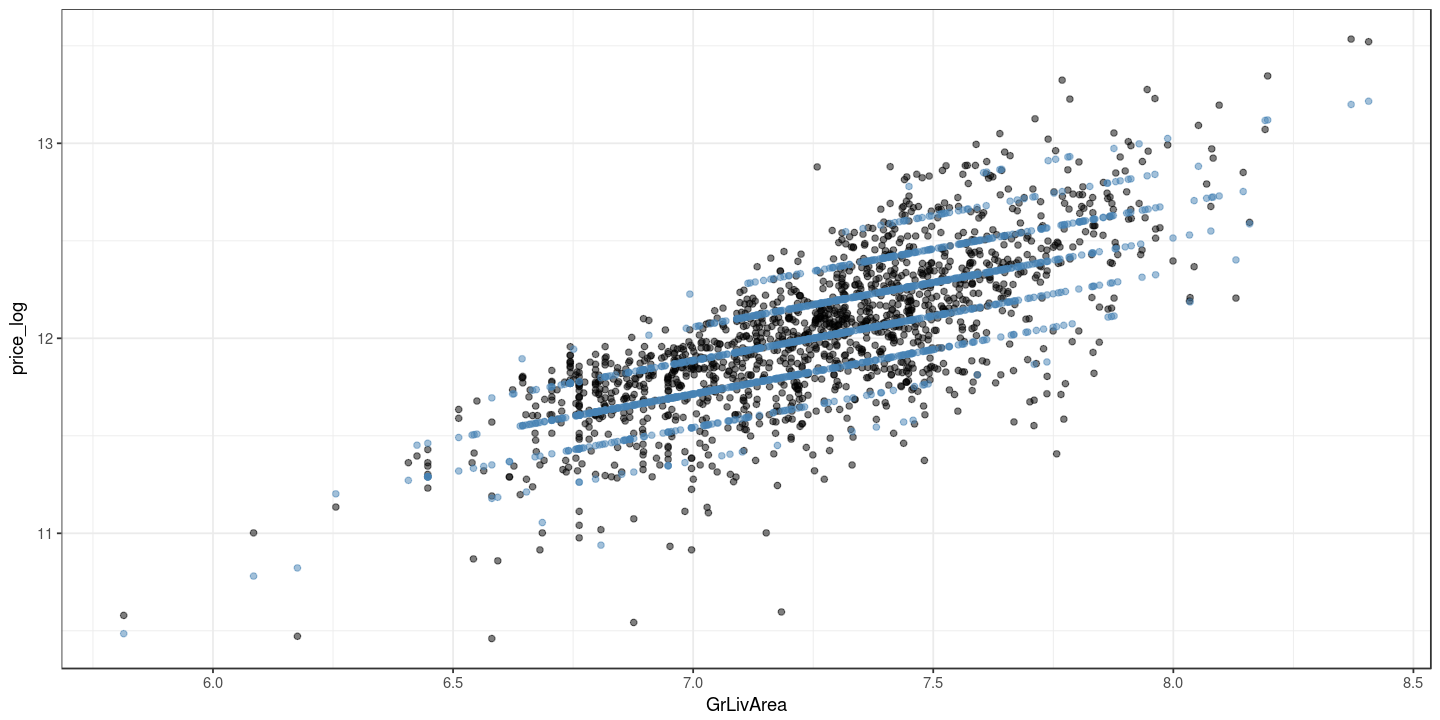

In [14]:
options(repr.plot.width = 12, repr.plot.height = 6)


mod <- lm(price_log ~ GrLivArea + OverallQual, data=training_dataset)

mod %>% glance
mod %>% tidy

mod %>%
ggplot() +
geom_point(aes(x=GrLivArea, y=price_log), alpha=0.5) +
geom_point(aes(x=GrLivArea, y=.fitted), alpha=0.5, color='steelblue') +
theme_bw()

In [79]:
all_predictors <- setdiff(colnames(training_dataset), 'price_log')
formula_str <- 'price_log ~ GrLivArea + OverallQual'
formula <- as.formula(formula_str)
remaining_predictors <- setdiff(all_predictors, labels(terms(formula)))

data_frame(
    base_formula = formula_str,
    var_name = remaining_predictors
    
) %>%
mutate(
    formula = paste0(base_formula, ' + ', var_name),
    base_r2 = summary(lm(as.formula(base_formula), data=training_dataset))$r.squared
) %>%
mutate(
    
    model = map(formula, ~lm(as.formula(.), data=training_dataset)),
    
    r2 = map_dbl(model, function (mod) {
        summary(mod)$r.squared
    }),
    
    r2_gain = r2 - base_r2,
    
    max_corr = map2_dbl(base_formula, var_name, function(base_formula, var_name) {
        df <- training_dataset
        base_vars <- labels(terms( as.formula(base_formula)))
        max(abs(cor(df[base_vars], df[var_name])))
    }),
    
    score = r2_gain / max_corr
) %>%
select(-model) %>%
arrange(desc(score)) %>%
head

base_formula,var_name,formula,base_r2,r2,r2_gain,max_corr,score
price_log ~ GrLivArea + OverallQual,BsmtFullBath,price_log ~ GrLivArea + OverallQual + BsmtFullBath,0.7641906,0.7942177,0.03002719,0.1040203,0.28866666
price_log ~ GrLivArea + OverallQual,BsmtFinSF1,price_log ~ GrLivArea + OverallQual + BsmtFinSF1,0.7641906,0.8112984,0.04710783,0.2224668,0.21175216
price_log ~ GrLivArea + OverallQual,MSZoning,price_log ~ GrLivArea + OverallQual + MSZoning,0.7641906,0.7976550,0.03346440,0.2709276,0.12351786
price_log ~ GrLivArea + OverallQual,LotArea,price_log ~ GrLivArea + OverallQual + LotArea,0.7641906,0.7950914,0.03090089,0.3744884,0.08251495
price_log ~ GrLivArea + OverallQual,CentralAir,price_log ~ GrLivArea + OverallQual + CentralAir,0.7641906,0.7858417,0.02165119,0.2725223,0.07944738
price_log ~ GrLivArea + OverallQual,TotalBsmtSF,price_log ~ GrLivArea + OverallQual + TotalBsmtSF,0.7641906,0.8061075,0.04191695,0.5385945,0.07782654


In [80]:
all_predictors <- setdiff(colnames(training_dataset), 'price_log')
formula_str <- 'price_log ~ GrLivArea + OverallQual + BsmtFullBath'
formula <- as.formula(formula_str)
remaining_predictors <- setdiff(all_predictors, labels(terms(formula)))

data_frame(
    base_formula = formula_str,
    var_name = remaining_predictors
    
) %>%
mutate(
    formula = paste0(base_formula, ' + ', var_name),
    base_r2 = summary(lm(as.formula(base_formula), data=training_dataset))$r.squared
) %>%
mutate(
    
    model = map(formula, ~lm(as.formula(.), data=training_dataset)),
    
    r2 = map_dbl(model, function (mod) {
        summary(mod)$r.squared
    }),
    
    r2_gain = r2 - base_r2,
    
    max_corr = map2_dbl(base_formula, var_name, function(base_formula, var_name) {
        df <- training_dataset
        base_vars <- labels(terms( as.formula(base_formula)))
        max(abs(cor(df[base_vars], df[var_name])))
    }),
    
    score = r2_gain / max_corr
) %>%
select(-model) %>%
arrange(desc(score)) %>%
head

base_formula,var_name,formula,base_r2,r2,r2_gain,max_corr,score
price_log ~ GrLivArea + OverallQual + BsmtFullBath,MSZoning,price_log ~ GrLivArea + OverallQual + BsmtFullBath + MSZoning,0.7942177,0.8221371,0.02791932,0.2709276,0.10305086
price_log ~ GrLivArea + OverallQual + BsmtFullBath,CentralAir,price_log ~ GrLivArea + OverallQual + BsmtFullBath + CentralAir,0.7942177,0.8117991,0.01758139,0.2725223,0.06451356
price_log ~ GrLivArea + OverallQual + BsmtFullBath,Neighborhood,price_log ~ GrLivArea + OverallQual + BsmtFullBath + Neighborhood,0.7942177,0.8364973,0.04227954,0.6790092,0.06226651
price_log ~ GrLivArea + OverallQual + BsmtFullBath,LotArea,price_log ~ GrLivArea + OverallQual + BsmtFullBath + LotArea,0.7942177,0.8172722,0.02305442,0.3744884,0.06156244
price_log ~ GrLivArea + OverallQual + BsmtFullBath,PavedDrive,price_log ~ GrLivArea + OverallQual + BsmtFullBath + PavedDrive,0.7942177,0.8077670,0.01354925,0.2299452,0.05892381
price_log ~ GrLivArea + OverallQual + BsmtFullBath,EnclosedPorch,price_log ~ GrLivArea + OverallQual + BsmtFullBath + EnclosedPorch,0.7942177,0.8005435,0.00632572,0.1131758,0.05589289


In [81]:
all_predictors <- setdiff(colnames(training_dataset), 'price_log')
formula_str <- 'price_log ~ GrLivArea + OverallQual + BsmtFullBath + MSZoning'
formula <- as.formula(formula_str)
remaining_predictors <- setdiff(all_predictors, labels(terms(formula)))

data_frame(
    base_formula = formula_str,
    var_name = remaining_predictors
    
) %>%
mutate(
    formula = paste0(base_formula, ' + ', var_name),
    base_r2 = summary(lm(as.formula(base_formula), data=training_dataset))$r.squared
) %>%
mutate(
    
    model = map(formula, ~lm(as.formula(.), data=training_dataset)),
    
    r2 = map_dbl(model, function (mod) {
        summary(mod)$r.squared
    }),
    
    r2_gain = r2 - base_r2,
    
    max_corr = map2_dbl(base_formula, var_name, function(base_formula, var_name) {
        df <- training_dataset
        base_vars <- labels(terms( as.formula(base_formula)))
        max(abs(cor(df[base_vars], df[var_name])))
    }),
    
    score = r2_gain / max_corr
) %>%
select(-model) %>%
arrange(desc(score)) %>%
head

base_formula,var_name,formula,base_r2,r2,r2_gain,max_corr,score
price_log ~ GrLivArea + OverallQual + BsmtFullBath + MSZoning,OverallCond,price_log ~ GrLivArea + OverallQual + BsmtFullBath + MSZoning + OverallCond,0.8221371,0.8293537,0.007216593,0.1499247,0.04813479
price_log ~ GrLivArea + OverallQual + BsmtFullBath + MSZoning,TotalBsmtSF,price_log ~ GrLivArea + OverallQual + BsmtFullBath + MSZoning + TotalBsmtSF,0.8221371,0.8430615,0.020924456,0.5385945,0.03885011
price_log ~ GrLivArea + OverallQual + BsmtFullBath + MSZoning,CentralAir,price_log ~ GrLivArea + OverallQual + BsmtFullBath + MSZoning + CentralAir,0.8221371,0.8326139,0.010476798,0.2725223,0.03844381
price_log ~ GrLivArea + OverallQual + BsmtFullBath + MSZoning,SaleCondition,price_log ~ GrLivArea + OverallQual + BsmtFullBath + MSZoning + SaleCondition,0.8221371,0.8342767,0.012139667,0.3230405,0.03757940
price_log ~ GrLivArea + OverallQual + BsmtFullBath + MSZoning,BsmtExposure,price_log ~ GrLivArea + OverallQual + BsmtFullBath + MSZoning + BsmtExposure,0.8221371,0.8343404,0.012203351,0.3367424,0.03623943
price_log ~ GrLivArea + OverallQual + BsmtFullBath + MSZoning,GarageArea,price_log ~ GrLivArea + OverallQual + BsmtFullBath + MSZoning + GarageArea,0.8221371,0.8418488,0.019711733,0.5572300,0.03537450


In [85]:
all_predictors <- setdiff(colnames(training_dataset), 'price_log')
formula_str <- 'price_log ~ GrLivArea + OverallQual + BsmtFullBath + MSZoning + CentralAir'
formula <- as.formula(formula_str)
remaining_predictors <- setdiff(all_predictors, labels(terms(formula)))

data_frame(
    base_formula = formula_str,
    var_name = remaining_predictors
    
) %>%
mutate(
    formula = paste0(base_formula, ' + ', var_name),
    base_r2 = summary(lm(as.formula(base_formula), data=training_dataset))$r.squared
) %>%
mutate(
    
    model = map(formula, ~lm(as.formula(.), data=training_dataset)),
    
    r2 = map_dbl(model, function (mod) {
        summary(mod)$r.squared
    }),
    
    r2_gain = r2 - base_r2,
    
    max_corr = map2_dbl(base_formula, var_name, function(base_formula, var_name) {
        df <- training_dataset
        base_vars <- labels(terms( as.formula(base_formula)))
        max(abs(cor(df[base_vars], df[var_name])))
    }),
    
    score = r2_gain / max_corr
) %>%
select(-model) %>%
arrange(desc(score)) %>%
head

base_formula,var_name,formula,base_r2,r2,r2_gain,max_corr,score
price_log ~ GrLivArea + OverallQual + BsmtFullBath + MSZoning + CentralAir,SaleCondition,price_log ~ GrLivArea + OverallQual + BsmtFullBath + MSZoning + CentralAir + SaleCondition,0.8326139,0.8447059,0.012091986,0.3230405,0.03743179
price_log ~ GrLivArea + OverallQual + BsmtFullBath + MSZoning + CentralAir,TotalBsmtSF,price_log ~ GrLivArea + OverallQual + BsmtFullBath + MSZoning + CentralAir + TotalBsmtSF,0.8326139,0.8520237,0.019409863,0.5385945,0.03603799
price_log ~ GrLivArea + OverallQual + BsmtFullBath + MSZoning + CentralAir,LotArea,price_log ~ GrLivArea + OverallQual + BsmtFullBath + MSZoning + CentralAir + LotArea,0.8326139,0.8453325,0.012718669,0.3744884,0.03396279
price_log ~ GrLivArea + OverallQual + BsmtFullBath + MSZoning + CentralAir,GarageArea,price_log ~ GrLivArea + OverallQual + BsmtFullBath + MSZoning + CentralAir + GarageArea,0.8326139,0.8502539,0.017640052,0.5572300,0.03165668
price_log ~ GrLivArea + OverallQual + BsmtFullBath + MSZoning + CentralAir,BsmtExposure,price_log ~ GrLivArea + OverallQual + BsmtFullBath + MSZoning + CentralAir + BsmtExposure,0.8326139,0.8431521,0.010538187,0.3367424,0.03129451
price_log ~ GrLivArea + OverallQual + BsmtFullBath + MSZoning + CentralAir,OverallCond,price_log ~ GrLivArea + OverallQual + BsmtFullBath + MSZoning + CentralAir + OverallCond,0.8326139,0.8371671,0.004553188,0.1499247,0.03036983


In [86]:
all_predictors <- setdiff(colnames(training_dataset), 'price_log')
formula_str <- 'price_log ~ GrLivArea + OverallQual + BsmtFullBath + MSZoning + CentralAir + SaleCondition'
formula <- as.formula(formula_str)
remaining_predictors <- setdiff(all_predictors, labels(terms(formula)))

data_frame(
    base_formula = formula_str,
    var_name = remaining_predictors
    
) %>%
mutate(
    formula = paste0(base_formula, ' + ', var_name),
    base_r2 = summary(lm(as.formula(base_formula), data=training_dataset))$r.squared
) %>%
mutate(
    
    model = map(formula, ~lm(as.formula(.), data=training_dataset)),
    
    r2 = map_dbl(model, function (mod) {
        summary(mod)$r.squared
    }),
    
    r2_gain = r2 - base_r2,
    
    max_corr = map2_dbl(base_formula, var_name, function(base_formula, var_name) {
        df <- training_dataset
        base_vars <- labels(terms( as.formula(base_formula)))
        max(abs(cor(df[base_vars], df[var_name])))
    }),
    
    score = r2_gain / max_corr
) %>%
select(-model) %>%
arrange(desc(score)) %>%
head

base_formula,var_name,formula,base_r2,r2,r2_gain,max_corr,score
price_log ~ GrLivArea + OverallQual + BsmtFullBath + MSZoning + CentralAir + SaleCondition,OverallCond,price_log ~ GrLivArea + OverallQual + BsmtFullBath + MSZoning + CentralAir + SaleCondition + OverallCond,0.8447059,0.8503724,0.005666556,0.14992469,0.03779602
price_log ~ GrLivArea + OverallQual + BsmtFullBath + MSZoning + CentralAir + SaleCondition,LotArea,price_log ~ GrLivArea + OverallQual + BsmtFullBath + MSZoning + CentralAir + SaleCondition + LotArea,0.8447059,0.8572889,0.012583042,0.37448836,0.03360062
price_log ~ GrLivArea + OverallQual + BsmtFullBath + MSZoning + CentralAir + SaleCondition,LotConfig,price_log ~ GrLivArea + OverallQual + BsmtFullBath + MSZoning + CentralAir + SaleCondition + LotConfig,0.8447059,0.8478419,0.003136042,0.09820923,0.03193226
price_log ~ GrLivArea + OverallQual + BsmtFullBath + MSZoning + CentralAir + SaleCondition,TotalBsmtSF,price_log ~ GrLivArea + OverallQual + BsmtFullBath + MSZoning + CentralAir + SaleCondition + TotalBsmtSF,0.8447059,0.8614701,0.016764236,0.53859453,0.03112589
price_log ~ GrLivArea + OverallQual + BsmtFullBath + MSZoning + CentralAir + SaleCondition,Functional,price_log ~ GrLivArea + OverallQual + BsmtFullBath + MSZoning + CentralAir + SaleCondition + Functional,0.8447059,0.8493984,0.004692537,0.16212673,0.02894363
price_log ~ GrLivArea + OverallQual + BsmtFullBath + MSZoning + CentralAir + SaleCondition,BsmtExposure,price_log ~ GrLivArea + OverallQual + BsmtFullBath + MSZoning + CentralAir + SaleCondition + BsmtExposure,0.8447059,0.8541004,0.009394574,0.33674235,0.02789840


In [87]:
all_predictors <- setdiff(colnames(training_dataset), 'price_log')
formula_str <- 'price_log ~ GrLivArea + OverallQual + BsmtFullBath + MSZoning + CentralAir + SaleCondition + OverallCond'
formula <- as.formula(formula_str)
remaining_predictors <- setdiff(all_predictors, labels(terms(formula)))

data_frame(
    base_formula = formula_str,
    var_name = remaining_predictors
    
) %>%
mutate(
    formula = paste0(base_formula, ' + ', var_name),
    base_r2 = summary(lm(as.formula(base_formula), data=training_dataset))$r.squared
) %>%
mutate(
    
    model = map(formula, ~lm(as.formula(.), data=training_dataset)),
    
    r2 = map_dbl(model, function (mod) {
        summary(mod)$r.squared
    }),
    
    r2_gain = r2 - base_r2,
    
    max_corr = map2_dbl(base_formula, var_name, function(base_formula, var_name) {
        df <- training_dataset
        base_vars <- labels(terms( as.formula(base_formula)))
        max(abs(cor(df[base_vars], df[var_name])))
    }),
    
    score = r2_gain / max_corr
) %>%
select(-model) %>%
arrange(desc(score)) %>%
head

base_formula,var_name,formula,base_r2,r2,r2_gain,max_corr,score
price_log ~ GrLivArea + OverallQual + BsmtFullBath + MSZoning + CentralAir + SaleCondition + OverallCond,TotalBsmtSF,price_log ~ GrLivArea + OverallQual + BsmtFullBath + MSZoning + CentralAir + SaleCondition + OverallCond + TotalBsmtSF,0.8503724,0.8701574,0.019784979,0.53859453,0.03673446
price_log ~ GrLivArea + OverallQual + BsmtFullBath + MSZoning + CentralAir + SaleCondition + OverallCond,LotArea,price_log ~ GrLivArea + OverallQual + BsmtFullBath + MSZoning + CentralAir + SaleCondition + OverallCond + LotArea,0.8503724,0.8615684,0.011196015,0.37448836,0.02989683
price_log ~ GrLivArea + OverallQual + BsmtFullBath + MSZoning + CentralAir + SaleCondition + OverallCond,LotConfig,price_log ~ GrLivArea + OverallQual + BsmtFullBath + MSZoning + CentralAir + SaleCondition + OverallCond + LotConfig,0.8503724,0.8532467,0.002874255,0.09820923,0.02926665
price_log ~ GrLivArea + OverallQual + BsmtFullBath + MSZoning + CentralAir + SaleCondition + OverallCond,Neighborhood,price_log ~ GrLivArea + OverallQual + BsmtFullBath + MSZoning + CentralAir + SaleCondition + OverallCond + Neighborhood,0.8503724,0.8702088,0.019836399,0.67900921,0.02921374
price_log ~ GrLivArea + OverallQual + BsmtFullBath + MSZoning + CentralAir + SaleCondition + OverallCond,GarageCars,price_log ~ GrLivArea + OverallQual + BsmtFullBath + MSZoning + CentralAir + SaleCondition + OverallCond + GarageCars,0.8503724,0.8677373,0.017364847,0.60074082,0.02890572
price_log ~ GrLivArea + OverallQual + BsmtFullBath + MSZoning + CentralAir + SaleCondition + OverallCond,YearBuilt,price_log ~ GrLivArea + OverallQual + BsmtFullBath + MSZoning + CentralAir + SaleCondition + OverallCond + YearBuilt,0.8503724,0.8667490,0.016376628,0.57136809,0.02866213


r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual
0.8503724,0.8496501,0.1549896,1177.247,0,8,653.49,-1288.98,-1241.417,34.83157,1450


term,estimate,std.error,statistic,p.value
(Intercept),6.48636253,0.113301649,57.248615,0.000000e+00
GrLivArea,0.48828807,0.015622784,31.254869,2.248191e-164
OverallQual,0.13325098,0.004045594,32.937306,4.260705e-178
BsmtFullBath,0.12476802,0.007988554,15.618349,6.057662e-51
MSZoning,0.13076449,0.009244401,14.145264,1.191901e-42
CentralAir,0.12028961,0.014094842,8.534300,3.501156e-17
SaleCondition,0.13689679,0.012101525,11.312359,1.712658e-28
OverallCond,0.02796103,0.003773248,7.410334,2.130901e-13


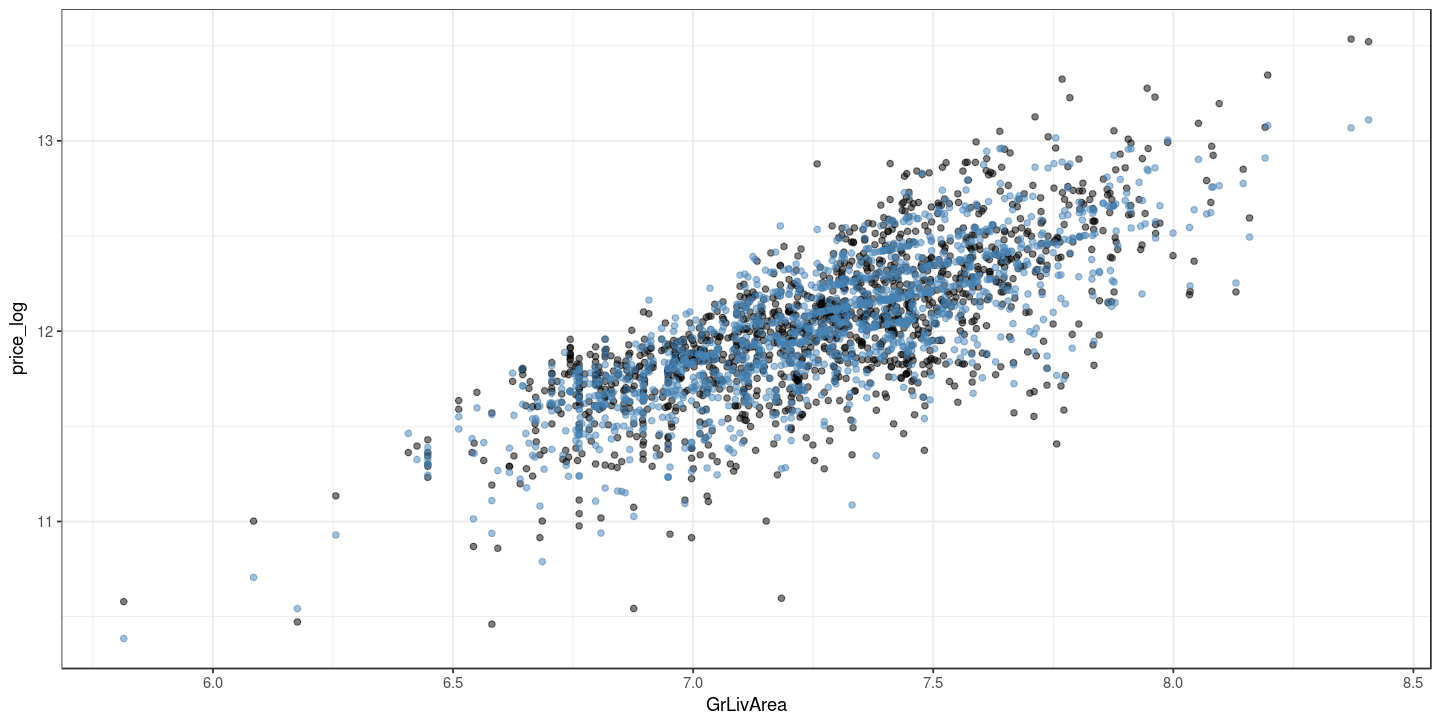

In [88]:
options(repr.plot.width = 12, repr.plot.height = 6)


mod <- lm(price_log ~ GrLivArea + OverallQual + BsmtFullBath + MSZoning + CentralAir + SaleCondition + OverallCond, data=training_dataset)

mod %>% glance
mod %>% tidy

mod %>%
ggplot() +
geom_point(aes(x=GrLivArea, y=price_log), alpha=0.5) +
geom_point(aes(x=GrLivArea, y=.fitted), alpha=0.5, color='steelblue') +
theme_bw()